In [54]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
from scipy import stats
from scipy import optimize
from scipy.linalg import block_diag

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from typing import Union, List, Tuple

"""
Own packages
"""
from codelib.portfolio_optimization.risk_metrics import drawdown, maxdrawdown
from codelib.statistics.moments import corr_to_cov_matrix, cov_to_corr_matrix, weighted_percentile, calculate_correlation

from codelib.visualization.base import correlation_plot, fan_chart
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.portfolio_optimization.black_litterman import calculate_capm_expected_return, calculate_bl_mu, calculate_bl_sigma
from codelib.portfolio_optimization.black_litterman import BlackLitterman

from codelib.portfolio_optimization.mean_variance import portfolio_variance


# Views
from codelib.statistics.fully_flexible_views import ProbabilitySolver, CorrelationView,MeanView, VolatilityView
from codelib.statistics.fully_flexible_views import effective_sample_size_entropy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercises - Week 11


## Problem 1:  Implementation of the Black-Litterman model

In this exercise, we will implement the Black-Litterman model in practice. 

__Question 1__

Obtain the Fama-French "12 industry portfolios" since 1999. Calculate the value weighted return index. What are the portfolio weights of each industry at the end of the sample?

__Question 2__

Calculate the average return for the industries. 

__Question 3__

Assume that $\lambda = 2.4$. Calculate the implied equilibrium expected returns. 

Is there a large difference compared to the ones calculated in question 2?

__Question 4__

We decide to implement the "extension" of the Black-Litterman model suggested by Meucci  (see [Meucci (2008), "The Black-Litterman Approach: Original Model and Extensions"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1117574)
). 

[Meucci (2008), "The Black-Litterman Approach: Original Model and Extensions"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1117574) suggests to simply set $\boldsymbol{\mu} = \boldsymbol{\pi}$ such that it is not a random variable and express our views directly on $\mathbf{R}$ using $\mathbf{P} \mathbf{R} = \mathbf{V}$ where we can think of the views as a random variable $\mathbf{V}$ with the conditional distribution 

$$
\mathbf{V} \vert \mathbf{r} \sim N(\mathbf{Pr}, \boldsymbol{\Omega})
$$

In practice, we will choose a specific value of $\mathbf{v}$. It is possible to show that 

$$
\mathbf{R} \vert \mathbf{v}, \boldsymbol{\Omega} \sim N(\boldsymbol{\mu}_{BL}^m, \boldsymbol{\Sigma}_{BL}^m)
$$

where 

\begin{align}
\boldsymbol{\mu}_{BL}^m &=  \boldsymbol{\pi} + \boldsymbol{\Sigma} \mathbf{P}^\top \left(\mathbf{P}   \boldsymbol{\Sigma} \mathbf{P}^\top + \boldsymbol{\Omega}\right)^{-1} (\mathbf{v} - \mathbf{P} \boldsymbol{\pi} ) \\
\boldsymbol{\Sigma}_{BL}^m &= \boldsymbol{\Sigma} - \boldsymbol{\Sigma} \mathbf{P}^\top \left(\mathbf{P}   \boldsymbol{\Sigma} \mathbf{P}^\top + \boldsymbol{\Omega} \right)^{-1} \mathbf{P} \boldsymbol{\Sigma}
\end{align}

Plot the market / reference distribution (probability density function) of the energy sector ('Enrgy').

__Qustion 5__

Implement the view that the Energy sector will return 20%. Consider three different confidence level $0.5, 1.0, 10.0$.

Plot the resulting distribution together with the reference distribution. What happens?

__Question 6__

Consider the views from above. How does the distribution of the telecom industry ('Telcm') change?

__Question 7__

Solve the minimization problem using the reference distribution 

$$
\underset{\mathbf{w}}{\text{arg min }} \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}
$$

subject to the budget constraint, a return target and positivity constraints

$$
\begin{align}
\mathbf{w}^\top \mathbf{1} &= 1 \\
\mathbf{w}^\top \boldsymbol{\mu} &= \bar{\mu}_p \\
w_i &\geq 0, \; i=1,..., N
\end{align}
$$

__Question 8__

Solve the minimization problem when assuming that: 

* The Energy sector will return 10%
* The Health Care sector ('Hlth') outperforms Durables sector ('Durbl') with 5%

Assume a confidence of 1.0. 

### Solution 

__Question 1__

In [55]:
reader = FamaFrenchReader("12_Industry_Portfolios", start=datetime.datetime(1999, 1, 1))
industry_port = reader.read()

# print description
industry_port['DESCR']

'12 Industry Portfolios\n----------------------\n\nThis file was created by CMPT_IND_RETS using the 202309 CRSP database. It contains value- and equal-weighted returns for 12 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2023 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (297 rows x 12 cols)\n  1 : Average Equal Weighted Returns -- Monthly (297 rows x 12 cols)\n  2 : Average Value Weighted Returns -- Annual (24 rows x 12 cols)\n  3 : Average Equal Weighted Returns -- Annual (24 rows x 12 cols)\n  4 : Number of Firms in Portfolios (297 rows x 12 cols)\n  5 : Average Firm Size (297 rows x 12 cols)\n  6 : Sum of BE / Sum of ME (25 rows x 12 cols)\n  7 : Value-Weighted Average of BE/ME (25 rows x 12 cols)'

In [56]:
# get equally weighted
ind_eq_weighted = industry_port[1] / 100
ind_eq_weighted.columns = ind_eq_weighted.columns.str.strip()
#ind_eq_weighted.index = pd.to_datetime(ind_eq_weighted.index, format="%Y-%m")

# get market cap weighted 
ind_mc_weighted = industry_port[0] / 100
ind_mc_weighted.columns = ind_mc_weighted.columns.str.strip()
#ind_mc_weighted.index = pd.to_datetime(ind_mc_weighted.index, format="%Y%m")

# get number of companies in each sector
num_companies = industry_port[4]
num_companies.columns = num_companies.columns.str.strip()
#num_companies.index = pd.to_datetime(num_companies.index, format="%Y%m")

# get average firm size 
avg_firm_size = industry_port[5]
avg_firm_size.columns = avg_firm_size.columns.str.strip()
#avg_firm_size.index = pd.to_datetime(avg_firm_size.index, format="%Y%m")

# get sector market cap 
sector_mkt_cap  = num_companies * avg_firm_size
total_mkt_cap = sector_mkt_cap.sum(axis=1)

# get relative market cap
sector_mkt_cap_relative = sector_mkt_cap.divide(total_mkt_cap, axis="rows")

# calculate market return 
market_return = (sector_mkt_cap_relative * ind_mc_weighted).sum(axis="columns")

# calculate equal weighted return 
equal_weighted_return = (ind_mc_weighted / 12.0).sum(axis="columns")

# asset list
asset_list = ind_mc_weighted.columns

In [57]:
mkt_index = (1 + market_return).cumprod()

In [58]:
sector_mkt_cap_relative.tail(1)

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
Date,,,,,,,,,,,,
2023-09,0.03755,0.026136,0.055558,0.038945,0.023855,0.361063,0.022262,0.027116,0.101142,0.095212,0.12406,0.087101


In [59]:
w_m = sector_mkt_cap_relative.tail(1).values.flatten()

In [60]:
w_m

array([0.03754964, 0.02613579, 0.05555832, 0.03894522, 0.02385501,
       0.36106251, 0.02226226, 0.02711614, 0.1011418 , 0.09521202,
       0.12405979, 0.08710149])

__Question 2__

In [61]:
asset_list

Index(['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils',
       'Shops', 'Hlth', 'Money', 'Other'],
      dtype='object')

In [135]:
# annualized hist. avg. returns
hist_returns = ind_mc_weighted.mean() * 12.0
hist_returns = hist_returns.values

pd.DataFrame(data=hist_returns, index=asset_list)*100

,0
NoDur,8.470707
Durbl,12.040404
Manuf,11.298182
Enrgy,11.892929
Chems,8.460606
BusEq,11.284444
Telcm,4.090909
Utils,8.385859
Shops,9.940202
Hlth,8.474747


__Question 3__

In [63]:
# annualized covariance matrix
cov_mat = ind_mc_weighted.cov().values * 12.0

In [137]:
capm_returns = BlackLitterman.calculate_eq_expected_return(cov_mat, w_m, 2.4)
pd.DataFrame(data=capm_returns, index=asset_list)*100*12

,0
NoDur,3.788601
Durbl,9.884434
Manuf,7.685277
Enrgy,6.597878
Chems,4.838249
BusEq,9.934548
Telcm,6.139293
Utils,3.143647
Shops,5.771146
Hlth,4.286259


__Question 4__

In [66]:
# specify Black-Litterman model (Meucci version) without any views
bl_model = BlackLitterman(cov_mat, capm_returns)

# calculate the posterior distribution (which should be the same as the reference distribution
# defined by cov_mat and pi (capm returns))
bl_model.calculate_posterior_distribution()

# Find the index of energy industry
idx_energy = np.where(asset_list=='Enrgy')[0][0]
idx_energy

3

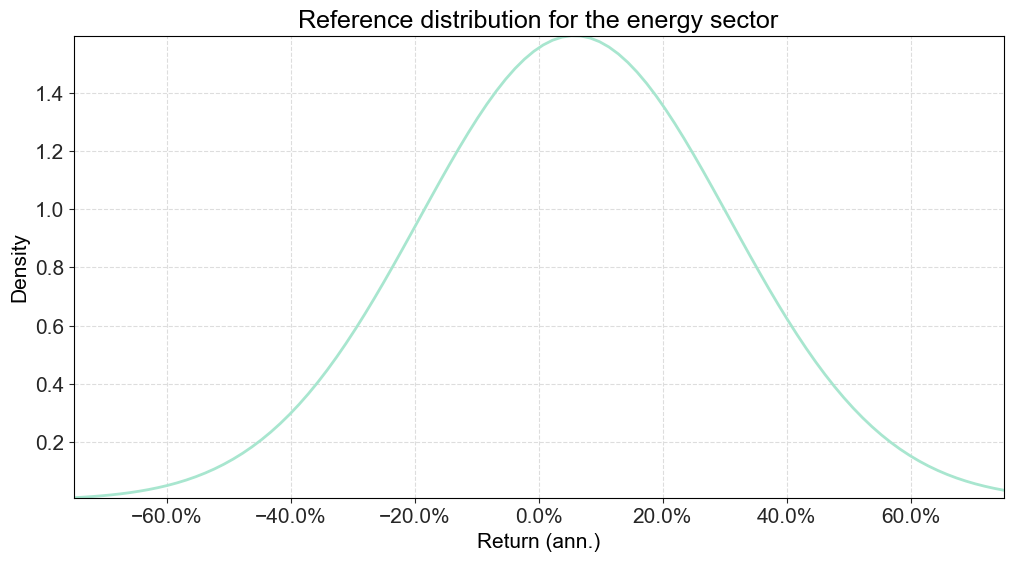

In [67]:
"""
Plot density of energy industry distribution 
"""
r_vals = np.linspace(-0.75, 0.75, 100)
mu_energy = bl_model.mean_posterior[idx_energy]
std_energy = np.sqrt(bl_model.cov_mat_posterior[idx_energy, idx_energy])
pdf_vals = stats.norm.pdf(r_vals, loc=mu_energy, scale=std_energy)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(r_vals, pdf_vals, label="Reference model")
ax.set_title("Reference distribution for the energy sector");
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1));
ax.set_xlabel("Return (ann.)");
ax.set_ylabel("Density");

__Question 5__

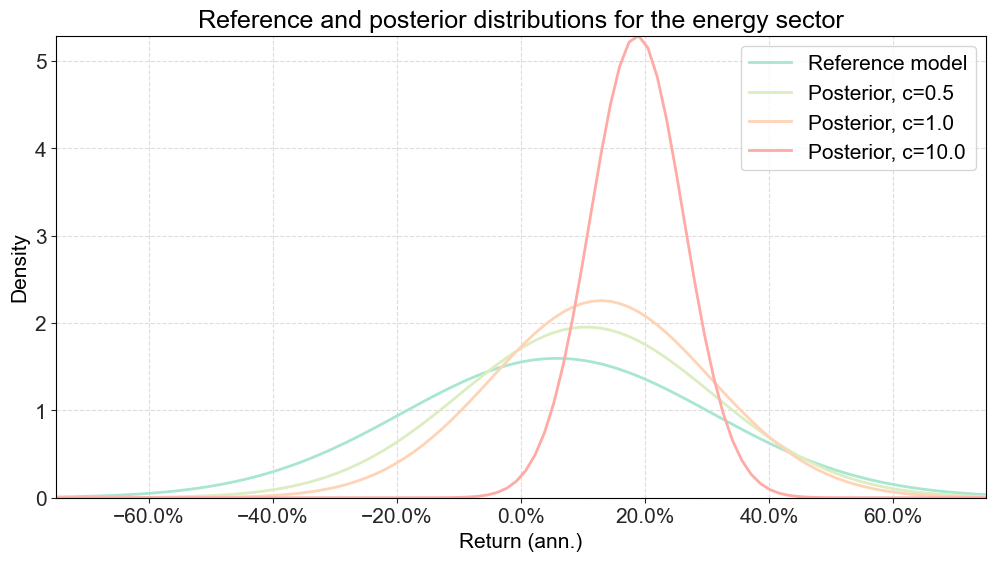

In [68]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(r_vals, pdf_vals, label="Reference model")

view = 0.2
for c in [0.5, 1.0, 10.0]:
    
    bl_model.clear_views()
    bl_model.add_equality_view(idx_energy, view)
    bl_model.calculate_posterior_distribution(confidence=c)
    
    mu_view = bl_model.mean_posterior[idx_energy]
    std_view = np.sqrt(bl_model.cov_mat_posterior[idx_energy, idx_energy])
    pdf_vals_view = stats.norm.pdf(r_vals, loc=mu_view, scale=std_view)
    
    ax.plot(r_vals, pdf_vals_view, label="Posterior, c={}".format(c))

ax.set_title("Reference and posterior distributions for the energy sector");
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1));
ax.set_xlabel("Return (ann.)");
ax.set_ylabel("Density");
ax.legend();

__Question 6__

In [69]:
bl_model.clear_views()
bl_model.calculate_posterior_distribution()

# Find the index of telecom industry
idx_telecom = np.where(asset_list=='Telcm')[0][0]
idx_telecom

6

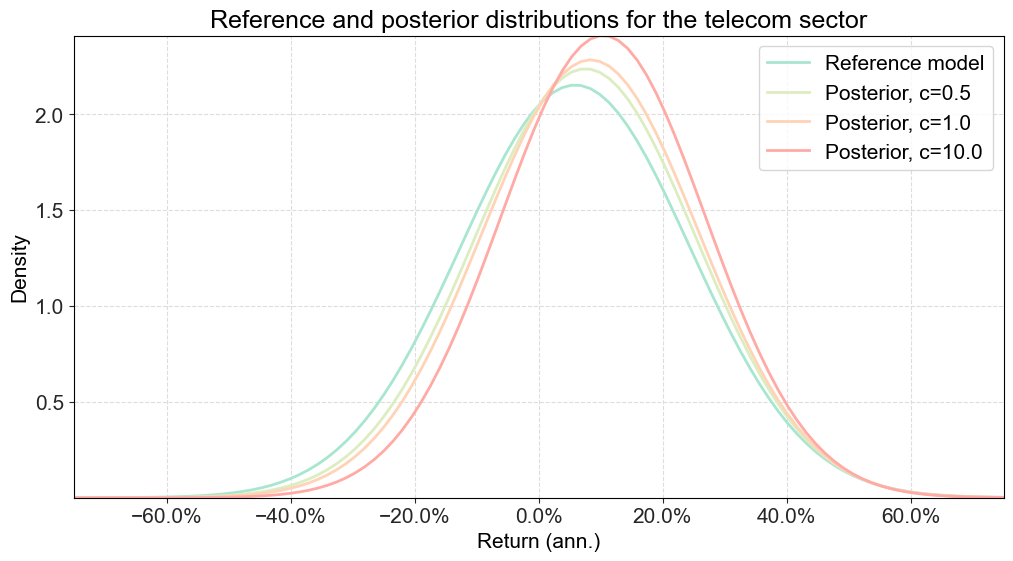

In [70]:
r_vals = np.linspace(-0.75, 0.75, 100)
mu_energy = bl_model.mean_posterior[idx_telecom]
std_energy = np.sqrt(bl_model.cov_mat_posterior[idx_telecom, idx_telecom])
pdf_vals = stats.norm.pdf(r_vals, loc=mu_energy, scale=std_energy)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(r_vals, pdf_vals, label="Reference model")

view = 0.2
for c in [0.5, 1.0, 10.0]:
    
    bl_model.clear_views()
    bl_model.add_equality_view(idx_energy, view)
    bl_model.calculate_posterior_distribution(confidence=c)
    
    mu_view = bl_model.mean_posterior[idx_telecom]
    std_view = np.sqrt(bl_model.cov_mat_posterior[idx_telecom, idx_telecom])
    pdf_vals_view = stats.norm.pdf(r_vals, loc=mu_view, scale=std_view)
    
    ax.plot(r_vals, pdf_vals_view, label="Posterior, c={}".format(c))

ax.set_title("Reference and posterior distributions for the telecom sector");
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1));
ax.set_xlabel("Return (ann.)");
ax.set_ylabel("Density");
ax.legend();

__Question 7__

In [71]:
bl_model.clear_views()
bl_model.calculate_posterior_distribution()

In [72]:
# define common constraints 
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0, 
                   'jac' : lambda x: np.ones_like(x)}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x,
                 'jac' : lambda x: np.eye(len(x))}

# alternatively use 
bounds = [(0.0, 1.0)] * len(bl_model.pi)

# set target returns
target_returns = np.linspace(0.03, 0.085, 100)

optimal_port_weights = []

x0 = np.ones_like(bl_model.pi) / len(bl_model.pi)

for target_return in target_returns: 
    
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: x @ bl_model.mean_posterior - target_return,
                   'jac' : lambda x: bl_model.mean_posterior}
    
    res = optimize.minimize(portfolio_variance, x0=x0, args=(bl_model.cov_mat_posterior,),
                            method='SLSQP',
                            constraints=[sum_to_one_cons, no_short_cons,  target_cons],  # no_short_cons,
                            options={'ftol': 1e-9, 'disp': False}) #, bounds=bounds)

    optimal_port_weights.append(res.x)


optimal_port_weights = np.array(optimal_port_weights)

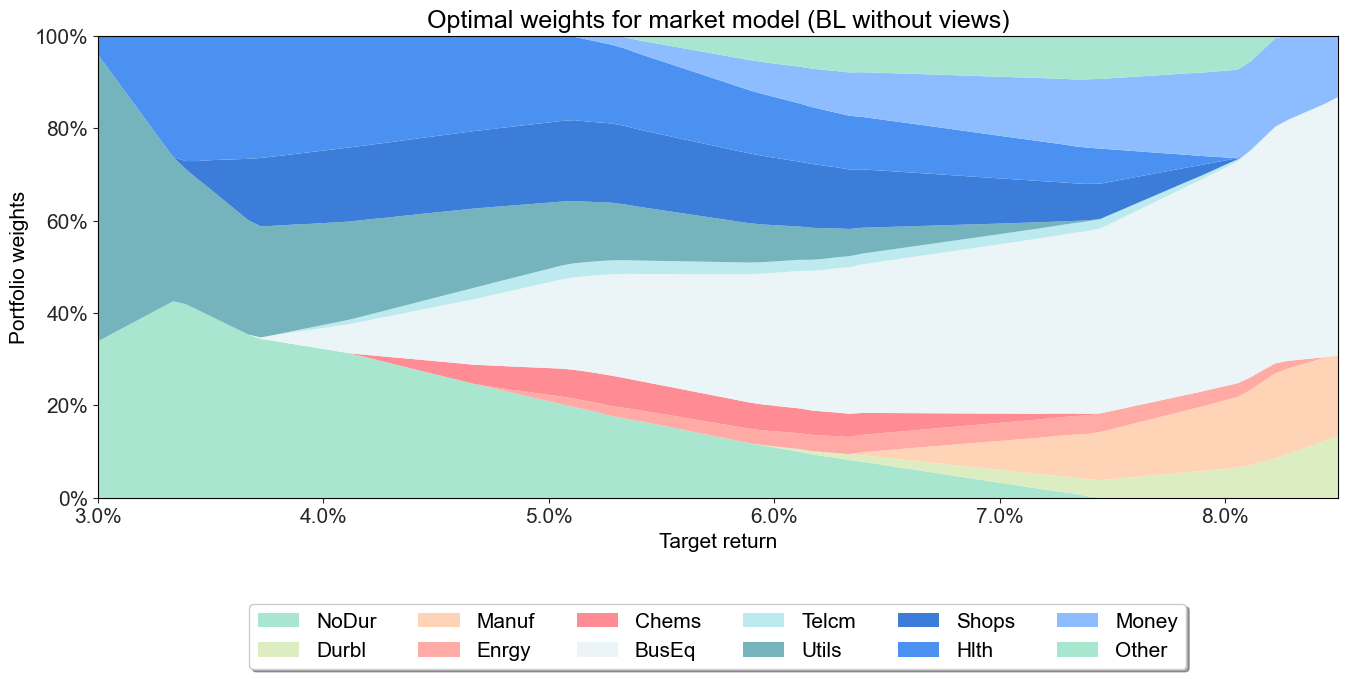

In [73]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(target_returns, optimal_port_weights.T, labels=asset_list);
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_xlabel("Target return")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights for market model (BL without views)")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=6);

__Question 8__

In [74]:
idx_healthcare = np.where(asset_list=='Hlth')[0][0]
idx_durables = np.where(asset_list=='Durbl')[0][0]

In [75]:
bl_model.clear_views()
bl_model.add_equality_view(idx_energy, 0.1)
bl_model.add_diff_view(idx_healthcare, idx_durables, 0.05)

bl_model.calculate_posterior_distribution(confidence=1.0)

In [76]:
bl_model.mean_posterior

array([0.03796075, 0.05207093, 0.06909473, 0.07895303, 0.04605925,
       0.07934122, 0.05813407, 0.03327379, 0.04742368, 0.0480834 ,
       0.06249321, 0.06191902])

In [77]:
# define common constraints 
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0, 
                   'jac' : lambda x: np.ones_like(x)}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x,
                 'jac' : lambda x: np.eye(len(x))}

# alternatively use 
bounds = [(0.0, 1.0)] * len(bl_model.pi)

# set target returns
target_returns = np.linspace(0.03, 0.075, 100)

optimal_port_weights = []

x0 = np.ones_like(bl_model.pi) / len(bl_model.pi)

for target_return in target_returns: 
    
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: x @ bl_model.mean_posterior - target_return,
                   'jac' : lambda x: bl_model.mean_posterior}
    
    res = optimize.minimize(portfolio_variance, x0=x0, args=(bl_model.cov_mat_posterior,),
                            method='SLSQP',
                            constraints=[sum_to_one_cons, no_short_cons,  target_cons],  # no_short_cons,
                            options={'ftol': 1e-9, 'disp': False}) #, bounds=bounds)

    optimal_port_weights.append(res.x)


optimal_port_weights = np.array(optimal_port_weights)

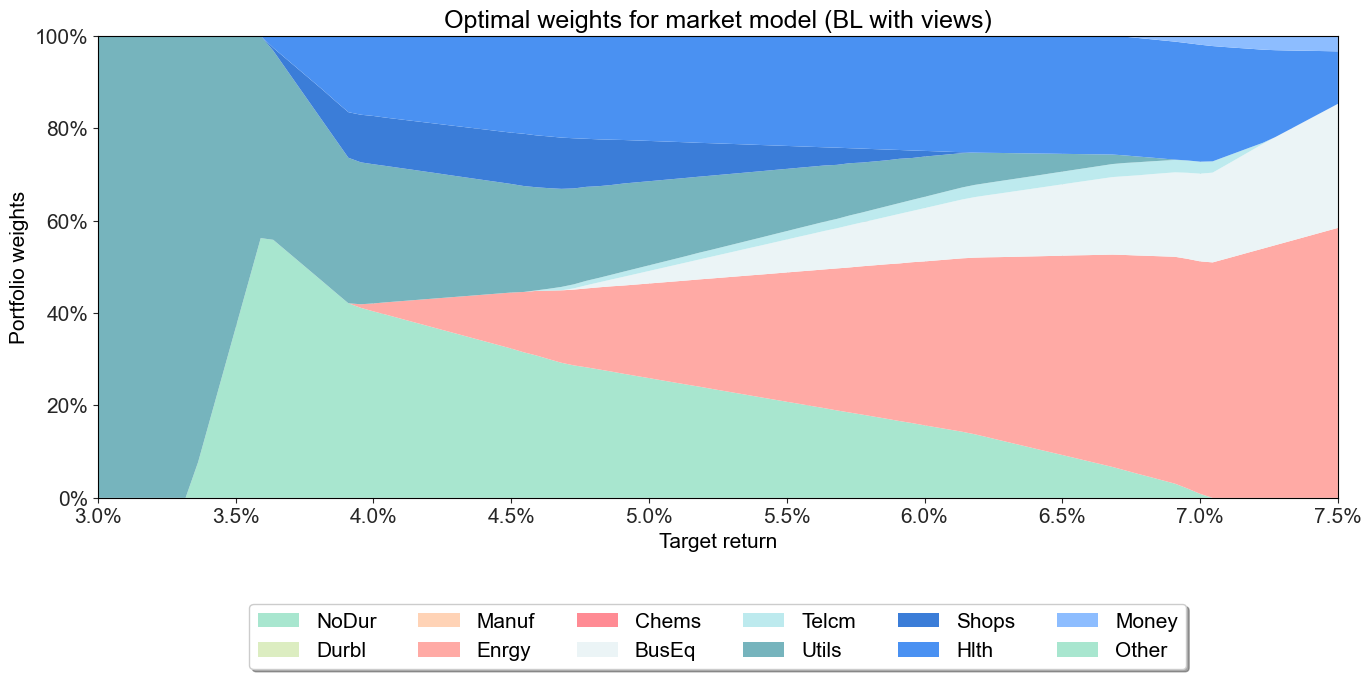

In [78]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(target_returns, optimal_port_weights.T, labels=asset_list);
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_xlabel("Target return")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights for market model (BL with views)")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=6);

In [79]:
corr_mat = cov_to_corr_matrix(cov_mat)

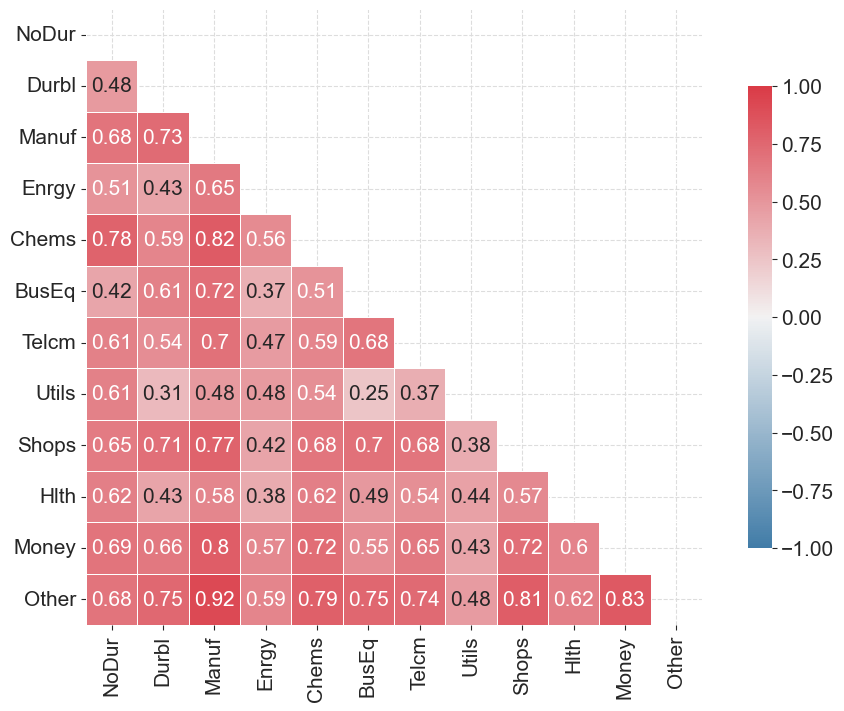

In [80]:
correlation_plot(corr_mat, names=asset_list, include_values=True)

fig = plt.gcf()

fig.set_size_inches((12, 8))

## Problem 2: Scenario analysis [Optional]

Assume that the (annual) log-returns of broad stock and bond indicies can be modelled as a bivariate normal distribution 

$$
\log (1  + \mathbf{R}) = \log \begin{bmatrix} 1 + R_{B} \\ 1 + R_{S} \end{bmatrix} \sim N\left(\boldsymbol{\mu}, 
\boldsymbol{\Sigma}\right)
$$

with 

$$
\boldsymbol{\mu} = \begin{bmatrix} 0.02 \\ 0.04 \end{bmatrix}
$$

and 

$$
\boldsymbol{\Sigma} = \begin{bmatrix} 0.1^2 & 0.0 \\ 0.0 & 0.16^2 \end{bmatrix}
$$


__Question 1__


Simulate 100,000 log-returns.  Estimate the correlation between stocks and bonds based on the simulated log-returns.

__Question 2__

What is the distribution of $1 + \mathbf{R}$? What is the mean and variance of $1 + \mathbf{R}$?

__Question 3__

Compare with the sample mean and variance estimates. 

__Question 4__

Consider an equally weighted portfolio of stock and bonds. What is the mean and variance of this portfolio?

__Question 5__

How does the result in the previous question compare with the simulated data?

__Question 6__

Plot a histogram with the equally weighted portfolio returns. 

__Question 7__

What is the probability of a return less than -10% (on the equally weighted portfolio)?

__Question 8__

We want to implement the view that the correlation between stocks and bonds are $\rho_{S,B} = 0.5$. Discuss how you will implement this view using the approach in [Attilio Meucci (2010), Fully Flexible Views: Theory and Practice](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1213325) and implement the view. 

__Question 9__

Plot the histogram of the original and weighted portfolio returns. 

__Question 10__

What is the probability of a portfolio return less than -10% (on the equally weighted portfolio) when taking the implemented view into account?

__Question 11__

Check that the correlation of the posterior distribution is $0.5$ (between the log-returns). 

### Solution 

__Question 1__

In [81]:
"""
Define relevant parameter values
"""

mu = np.array([0.02, 0.04])
vols = np.array([0.1, 0.16])
corr_mat = np.eye(2)
cov_mat = corr_to_cov_matrix(corr_mat, vols)

"""
Simulate values
"""
num_sim = 100000
sim_log_returns = np.random.multivariate_normal(mu, cov_mat, size=num_sim)

"""
Calculate correlation 
"""

np.corrcoef(sim_log_returns, rowvar=False)

array([[ 1.        , -0.00393482],
       [-0.00393482,  1.        ]])

__Question 2__

Since $\log 1 + \mathbf{R}$ is normally distributed then $1 + \mathbf{R}$ follows a log-normal distribution. From the properties of a [multivariate log-normal distribution](https://www.casact.org/sites/default/files/database/forum_15spforum_halliwell.pdf) then 

$$
\text{E}[1 + \mathbf{R}] = e^{\boldsymbol{\mu} + \frac{1}{2} \text{diag}\boldsymbol{\Sigma}}
$$

and 

$$
\text{Var}[1 + \mathbf{R}] = \text{E}[1 + \mathbf{R}] \text{E}[1 + \mathbf{R}]^\top \odot \left( e^{\boldsymbol{\Sigma}} - \mathbf{1}_{N \times N}\right)
$$

In [82]:
def transform_moments_from_norm_to_log_norm(mu: np.ndarray, cov_mat: np.ndarray) -> Tuple[np.ndarray, np.ndarray]: 
    
    """
    Calulates the mean and covariance of a multivariate log-normal distribution
    
    Parameters
    ----------
    mu: 
        Expected value of log X.
    cov_mat: 
        Covariance matrix of log X.
        
    Returns
    Tuple[np.ndarray, np.ndarray]
        Expected value and covariance matrix of X. 
    
    """
    
    mu_new = np.exp(mu + 0.5 * np.diag(cov_mat))
    
    cov_mat_new = np.outer(mu_new, mu_new) * (np.exp(cov_mat) - np.ones_like(cov_mat))
    
    return mu_new, cov_mat_new

In [83]:
mu_gross_returns, cov_mat_gross_returns = transform_moments_from_norm_to_log_norm(mu, cov_mat)

In [84]:
mu_gross_returns

array([1.02531512, 1.05421878])

In [85]:
cov_mat_gross_returns

array([[0.01056545, 0.        ],
       [0.        , 0.02881856]])

__Question 3__

In [86]:
sim_gross_returns = np.exp(sim_log_returns)

In [87]:
est_mu_gross_return = np.mean(sim_gross_returns, axis=0)
est_mu_gross_return

array([1.02490416, 1.0541154 ])

In [88]:
est_cov_mat_gross_return = np.cov(sim_gross_returns, rowvar=False)
est_cov_mat_gross_return

array([[ 1.05941473e-02, -7.16559828e-05],
       [-7.16559828e-05,  2.88514847e-02]])

__Question 4__

We want to find the mean and variance

$$
\mathbf{w}^\top \text{E}[\mathbf{R}] = \mathbf{w}^\top \text{E}[1 + \mathbf{R} - 1] =\mathbf{w}^\top \left[ e^{\boldsymbol{\mu} + \frac{1}{2} \text{diag}\boldsymbol{\Sigma}} - 1\right]
$$

and

$$
\mathbf{w}^\top \text{Var}[\mathbf{R}]\mathbf{w} = \mathbf{w}^\top \text{Var}[ 1 + \mathbf{R}]\mathbf{w} = \mathbf{w}^\top \text{E}[1 + \mathbf{R}] \text{E}[1 + \mathbf{R}]^\top \odot \left( e^{\boldsymbol{\Sigma}} - \mathbf{1}_{N \times N}\right)\mathbf{w} 
$$

where $\mathbf{w} = [0.5, 0.5]^\top$

In [89]:
w_eq = np.repeat(0.5, 2)

port_mean_eq = w_eq @ (mu_gross_returns - 1)
port_var_eq = w_eq @ cov_mat_gross_returns @ w_eq 

In [90]:
port_mean_eq

0.039766950400974

In [91]:
port_var_eq

0.009846002787160964

__Question 5__

In [92]:
sim_net_returns = sim_gross_returns - 1
sim_port_returns = sim_net_returns @ w_eq

In [93]:
port_mean_eq_sim = np.mean(sim_port_returns)
port_var_eq_sim = np.var(sim_port_returns)

In [94]:
port_mean_eq_sim

0.03950977914399672

In [95]:
port_var_eq_sim

0.009825481757873806

__Question 6__

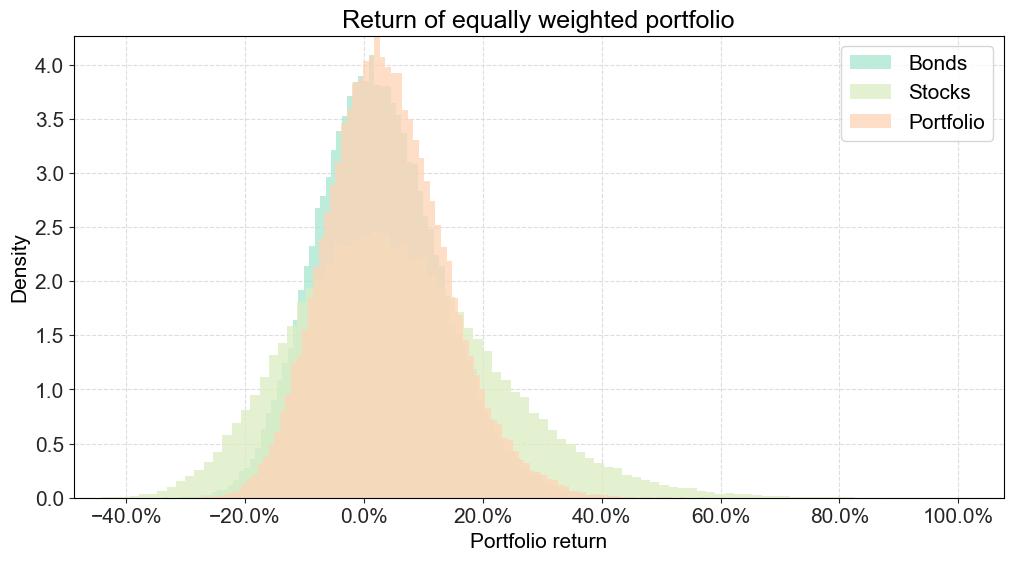

In [96]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(sim_net_returns[:, 0], density=True, bins=100, label="Bonds", alpha=0.75);
ax.hist(sim_net_returns[:, 1], density=True, bins=100, label="Stocks", alpha=0.75);
ax.hist(sim_port_returns, density=True, bins=100, label="Portfolio", alpha=0.75);
ax.set_xlabel("Portfolio return")
ax.set_ylabel("Density")
ax.set_title("Return of equally weighted portfolio")
ax.legend();
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1));

__Question 7__

In [97]:
def calculate_prob_less_than(data: np.ndarray, value: float, probs=None):
    
    idx_smaller = data < value
    
    if probs is None: 
        return np.sum(idx_smaller) / len(data)
    else: 
        return probs[idx_smaller].sum()

In [98]:
prob_less = calculate_prob_less_than(sim_port_returns, -0.1, probs=None)
prob_less

0.06954

__Question 8__

The approach of [Attilio Meucci (2010), Fully Flexible Views: Theory and Practice](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1213325) allows us to implement views that are defined as linear constraints on the probabilities. However, many relevant non-linear views can be implemented by redefining the views. 

If we want to define a view on the expected value of a random variable $X$ such that its expected value is equal to $c$, we could simply define 

$$
\mathbf{x}^\top \tilde{\mathbf{p}} = \sum_{j=1}^J x_{j} \tilde{p}_i = c
$$

The direct approach to specify a view on the covariance between the two random variables $X$ and $Y$ would be (equal to b)

$$
[( \mathbf{x} - \mathbf{x}^\top \tilde{\mathbf{p}}) \odot (\mathbf{y} - \mathbf{y}^\top \tilde{\mathbf{p}})]^\top \tilde{\mathbf{p}} = b
$$

which is non-linear on the probabilities and so will a view on the correlation. 

We realize that we can write the covariance between two random variables $X$ and $Y$ as 

$$
\rho_{X,Y} \sigma_X \sigma_Y = \text{Cov}[X, Y] = \text{E}[XY] - \text{E}[X]\text{E}[Y] = \text{E}[XY] - \mu_X \mu_Y
$$

which gives us 

$$
\text{E}[XY] = \mu_X \mu_Y + \rho_{X,Y} \sigma_X \sigma_Y 
$$

Thus, we can we define the constraint as 

$$
[\mathbf{x}  \odot \mathbf{y}]^\top \tilde{\mathbf{p}} = \mu_X \mu_Y + \rho_{X,Y} \sigma_X \sigma_Y 
$$

requiring us to also have a view on expected values and volatilities. However, if we have an agnostic view on expected values and volatilities, we can simply set them equal to the ones of the prior / reference distribution. 


In [99]:
mean_view_1 = MeanView('eq', sim_log_returns[:, 0], mu[0])
mean_view_2 = MeanView('eq', sim_log_returns[:, 1], mu[1])
vol_view_1 = VolatilityView('eq', sim_log_returns[:, 0], mu[0], vols[0])
vol_view_2 = VolatilityView('eq', sim_log_returns[:, 1], mu[1], vols[1])
corr_view = CorrelationView('eq', sim_log_returns[:, 0], sim_log_returns[:, 1], mu[0], mu[1], vols[0], vols[1], 0.5)

In [100]:
init_probs = np.ones_like(sim_log_returns[:, 0]) / len(sim_log_returns[:, 0])

view_solver = ProbabilitySolver(init_probs, [mean_view_1, mean_view_2, vol_view_1, vol_view_2, corr_view])
view_probs = view_solver.minimize_entropy()

__Question 9__

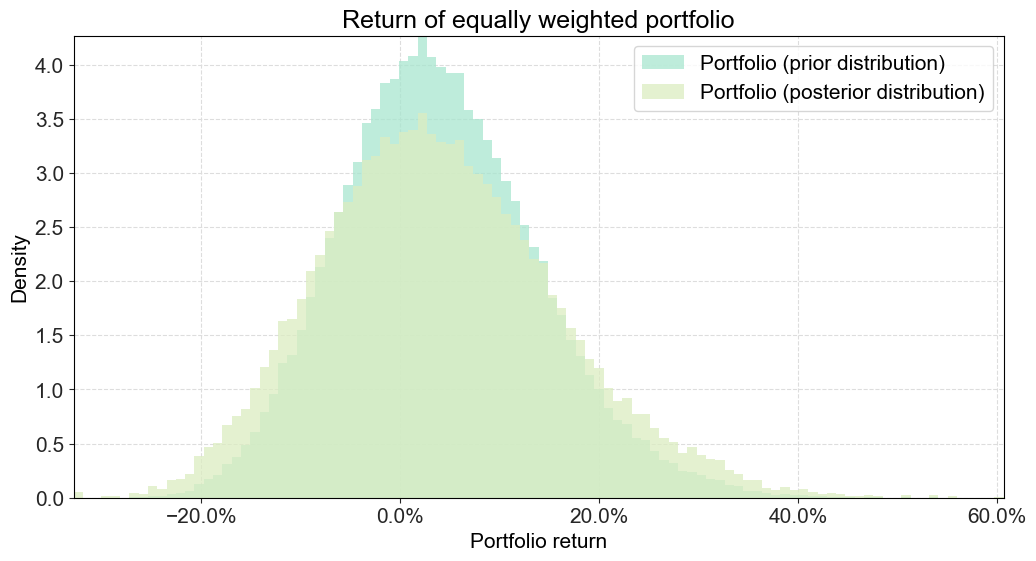

In [101]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(sim_port_returns, density=True, bins=100, label="Portfolio (prior distribution)", alpha=0.75);
ax.hist(sim_port_returns, density=True, bins=100, label="Portfolio (posterior distribution)", alpha=0.75,
        weights=view_probs);
ax.set_xlabel("Portfolio return")
ax.set_ylabel("Density")
ax.set_title("Return of equally weighted portfolio")
ax.legend();
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1));

__Question 10__

In [102]:
prob_less_view = calculate_prob_less_than(sim_port_returns, -0.1, probs=view_probs)
prob_less_view

0.11376686307519229

__Question 11__

In [103]:
calculate_correlation(sim_log_returns[:, 0], sim_log_returns[:, 1], probs=view_probs)

0.49999836919420526

## Problem 3: Portfolio optimization with views [Optional]

In this problem, we will perform portfolio optimization after applying views. 

__Question 1__

Obtain the Fama-French "12 industry portfolios" since 1999. Calculate the value weighted return index. 

Calculate log-returns of the market portfolio and the industry portfolios. 

__Question 2__

We will assume that we can model the log-returns of the industry portfolios using a one-factor model. Let $\mathbf{x}$ denote the $N \times 1$ vector of log-returns and let $f$ denote the  market log-return, then 

$$
\mathbf{x} = \boldsymbol{\alpha} + \boldsymbol{\beta} f + \mathbf{u}
$$

where $\boldsymbol{\beta}$ ($N \times 1$) denotes the market betas and $\mathbf{u} \sim N(\mathbf{0}, \boldsymbol{\Omega})$ denotes the the error terms that are assumed to be normally distributed with a diagonal covariance matrix. 

Calculate the market betas. This can be done using standard OLS. 

__Question 3__

The implied covariance matrix is given by 

$$
\text{Cov}[\mathbf{x}] = \boldsymbol{\beta} \text{Var}[f] \boldsymbol{\beta}^T + \boldsymbol{\Omega}
$$

We can estimate $\text{Var}[f]$ as the sample variance of the market log-return and we can estimate the diagonal elements of $\boldsymbol{\Omega}$ as the sample variance of the residuals. 

Calculate the covariance matrix of the log-returns given the one-factor model and compare with the sample covariance matrix of the log-returns. 

__Question 4__

We will assume that $\boldsymbol{\alpha} = \mathbf{0}$ and assume that 1-year market log-return is distributed as 

$$
\log (1 + R_{mkt}) \sim N(\mu_{mkt}, \text{Var}[f] \cdot 12)
$$

where $\text{Var}[f]$ is the variance obtained using the monthly log-returns. $\mu_{mkt}$ is the expected market log-return. 

We will try to find the optimal asset allocaiton in three cases (bear, bull and neutral market)

$$
\mu_{mkt} = 0.05 \pm \sigma_{mkt}
$$

where $\sigma_{mkt}$ refers to the market standard deviation (annual). 

Simulate 100,000 annual log-returns for the 12 assets when $\mu_{mkt} = 0.05$. Calculate gross and net returns. Plot the histogram of the 1-year portfolio returns of an equally weighted portfolio. 

__Question 5__

Plot the histogram of the equally weighted portfolio when applying the bull and bear view. 

__Question 6__

Implement Mean-CVaR optimization method that allows for views. 

__Question 7__

Minimize the CVaR(5%). Are the results as expected?



### Solution 

__Question 1__

In [104]:
reader = FamaFrenchReader("12_Industry_Portfolios", start=datetime.datetime(1999, 1, 1))
industry_port = reader.read()

# print description
industry_port['DESCR']

'12 Industry Portfolios\n----------------------\n\nThis file was created by CMPT_IND_RETS using the 202309 CRSP database. It contains value- and equal-weighted returns for 12 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2023 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (297 rows x 12 cols)\n  1 : Average Equal Weighted Returns -- Monthly (297 rows x 12 cols)\n  2 : Average Value Weighted Returns -- Annual (24 rows x 12 cols)\n  3 : Average Equal Weighted Returns -- Annual (24 rows x 12 cols)\n  4 : Number of Firms in Portfolios (297 rows x 12 cols)\n  5 : Average Firm Size (297 rows x 12 cols)\n  6 : Sum of BE / Sum of ME (25 rows x 12 cols)\n  7 : Value-Weighted Average of BE/ME (25 rows x 12 cols)'

In [105]:
# get equally weighted
ind_eq_weighted = industry_port[1] / 100
ind_eq_weighted.columns = ind_eq_weighted.columns.str.strip()
#ind_eq_weighted.index = pd.to_datetime(ind_eq_weighted.index, format="%Y-%m")

# get market cap weighted 
ind_mc_weighted = industry_port[0] / 100
ind_mc_weighted.columns = ind_mc_weighted.columns.str.strip()
#ind_mc_weighted.index = pd.to_datetime(ind_mc_weighted.index, format="%Y%m")

# get number of companies in each sector
num_companies = industry_port[4]
num_companies.columns = num_companies.columns.str.strip()
#num_companies.index = pd.to_datetime(num_companies.index, format="%Y%m")

# get average firm size 
avg_firm_size = industry_port[5]
avg_firm_size.columns = avg_firm_size.columns.str.strip()
#avg_firm_size.index = pd.to_datetime(avg_firm_size.index, format="%Y%m")

# get sector market cap 
sector_mkt_cap  = num_companies * avg_firm_size
total_mkt_cap = sector_mkt_cap.sum(axis=1)

# get relative market cap
sector_mkt_cap_relative = sector_mkt_cap.divide(total_mkt_cap, axis="rows")

# calculate market return 
market_return = (sector_mkt_cap_relative * ind_mc_weighted).sum(axis="columns")

# calculate equal weighted return 
equal_weighted_return = (ind_mc_weighted / 12.0).sum(axis="columns")

# asset list
asset_list = ind_mc_weighted.columns

In [106]:
mkt_index = (1 + market_return).cumprod()
mkt_log_returns = np.log(1 + market_return)

log_returns = np.log(1 + ind_mc_weighted)

In [107]:
log_returns

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
Date,,,,,,,,,,,,
1999-01,-0.035420,0.050693,0.021468,-0.057311,-0.040405,0.140979,0.085719,-0.064432,0.022153,0.002198,0.003195,0.029753
1999-02,-0.040614,-0.047196,-0.030253,-0.032213,0.006777,-0.122055,-0.029326,-0.036871,-0.013795,0.001798,0.006380,-0.021121
1999-03,-0.020407,-0.002503,0.043059,0.143321,0.056002,0.081396,-0.009646,-0.016536,0.026545,0.024888,0.029656,0.004390
1999-04,0.038451,0.092853,0.082409,0.147040,0.108854,0.022544,0.074551,0.070924,0.004390,-0.056888,0.061377,0.074922
1999-05,0.013508,-0.047196,-0.028605,-0.031491,-0.043534,-0.007629,0.010247,0.065038,-0.031181,-0.020509,-0.039365,-0.041030
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05,-0.054984,0.126809,-0.042281,-0.099931,-0.089159,0.079273,-0.098716,-0.059962,0.006181,-0.037390,-0.038429,-0.008435
2023-06,0.028004,0.220420,0.109572,0.062223,0.083330,0.057042,0.045260,0.025765,0.075942,0.045547,0.057042,0.093672
2023-07,0.022935,0.026934,0.037392,0.070831,0.017742,0.042293,0.009752,0.027518,0.022544,-0.001101,0.062035,0.034498


__Question 2__

In [108]:
y_mat = log_returns.values
x_mat = np.c_[np.ones(len(mkt_log_returns)), mkt_log_returns.values]

In [109]:
beta_est = np.linalg.inv(x_mat.T @ x_mat) @ x_mat.T @ y_mat

In [110]:
# beta estimates
beta_est[1, :]

array([0.57702763, 1.49771225, 1.17969821, 0.9681451 , 0.74370982,
       1.3402163 , 0.94334786, 0.47105052, 0.87078412, 0.62779626,
       1.07151941, 1.07329513])

In [111]:
# alpha estimates
beta_est[0, :]

array([ 0.00281605, -0.00316191,  0.00043719,  0.00135504,  0.00153333,
       -0.0013103 , -0.00380835,  0.00314587,  0.00184562,  0.00233889,
       -0.00170235, -0.00192488])

__Question 3__

In [112]:
# residuals
resids = y_mat - x_mat @ beta_est

In [113]:
# residual covariance matrix, Omega
residual_variance = np.var(resids, axis=0)
residual_cov_mat = np.diag(residual_variance)

In [114]:
# covariance mat, factor structure
cov_mat = np.outer(beta_est[1, :], beta_est[1, :]) * np.var(mkt_log_returns.values) + residual_cov_mat

sample_cov_mat = np.cov(log_returns.values, rowvar=False, )

In [115]:
corr_mat = cov_to_corr_matrix(cov_mat)
sample_corr_mat = cov_to_corr_matrix(sample_cov_mat)

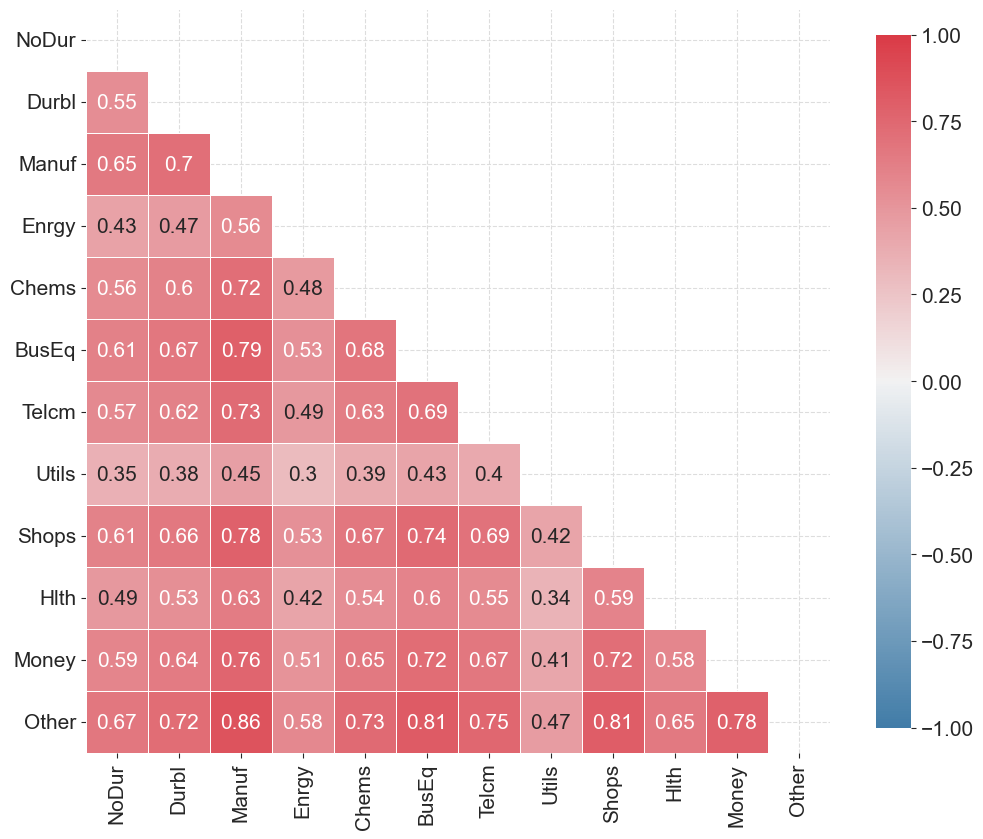

In [116]:
"""
Factor model
"""

fig, ax = plt.subplots(figsize=(12, 12))
correlation_plot(corr_mat, names=asset_list, include_values=True, ax=ax)

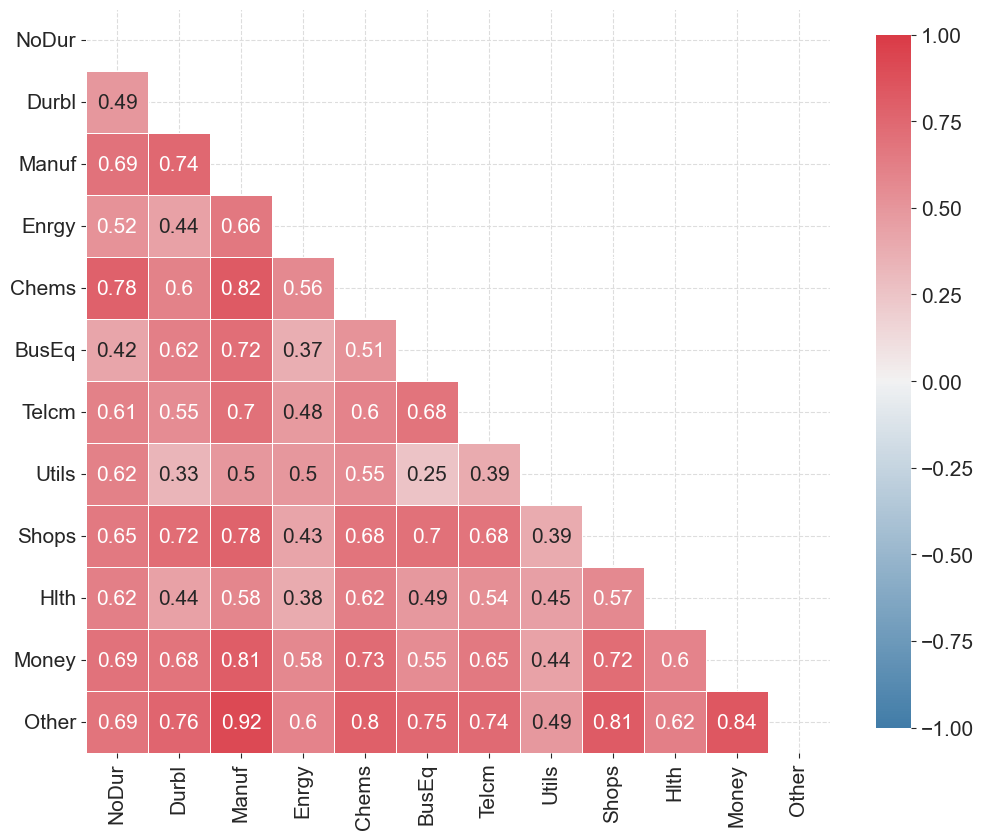

In [117]:
"""
Sample covariance
"""

fig, ax = plt.subplots(figsize=(12, 12))
correlation_plot(sample_corr_mat, names=asset_list, include_values=True, ax=ax)

__Question 4__

In [118]:
"""
Simulate values
"""
mu_mkt = 0.05
var_mkt = np.var(mkt_log_returns.values) * 12.0
std_mkt = np.sqrt(var_mkt)
num_sim = 100000
sim_mkt_log_returns = np.random.normal(loc=mu_mkt, scale=std_mkt, size=num_sim)
sim_log_returns = (sim_mkt_log_returns[:, None]  * beta_est[1, :] +  
                   np.random.multivariate_normal(np.zeros(12), residual_cov_mat*12, size=num_sim))

In [119]:
sim_gross_returns = np.exp(sim_log_returns)

In [120]:
sim_net_returns = sim_gross_returns - 1.0

In [121]:
w_eq = np.ones(12) / 12
#w_eq = np.zeros(12)
#w_eq[5] = 1.0
sim_port_returns = sim_net_returns @ w_eq

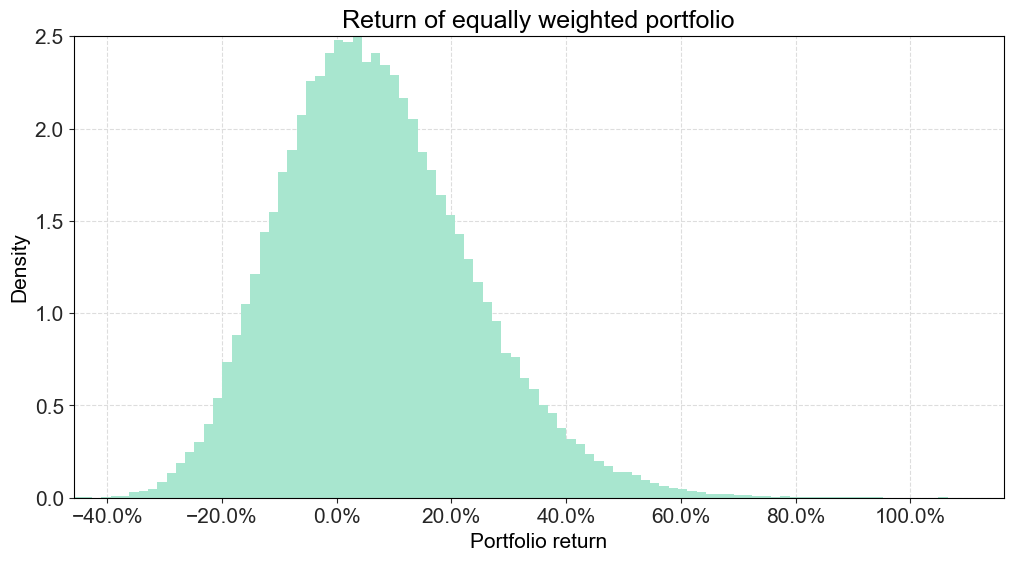

In [122]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(sim_port_returns, density=True, bins=100, label="Portfolio", alpha=1.0);
ax.set_xlabel("Portfolio return")
ax.set_ylabel("Density")
ax.set_title("Return of equally weighted portfolio")
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1));

__Question 5__

In [123]:
mean_view_bear = MeanView('eq', sim_mkt_log_returns, mu_mkt - std_mkt)
mean_view_bull = MeanView('eq', sim_mkt_log_returns, mu_mkt + std_mkt)
init_probs = np.ones_like(sim_mkt_log_returns) / len(sim_mkt_log_returns)

view_solver = ProbabilitySolver(init_probs, [mean_view_bear])
bear_probs = view_solver.minimize_entropy()

view_solver = ProbabilitySolver(init_probs, [mean_view_bull])
bull_probs = view_solver.minimize_entropy()

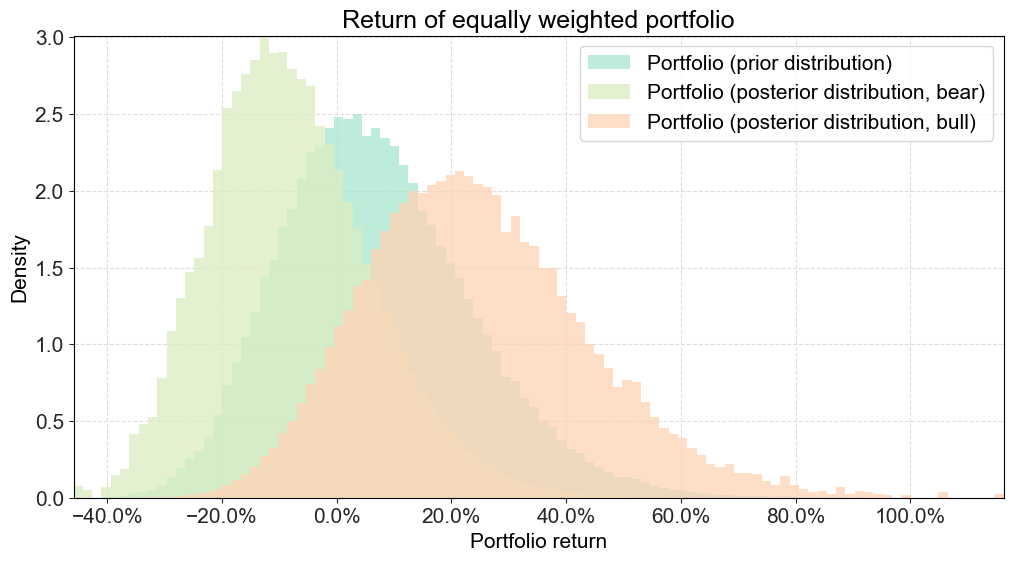

In [124]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(sim_port_returns, density=True, bins=100, label="Portfolio (prior distribution)", alpha=0.75);
ax.hist(sim_port_returns, density=True, bins=100, label="Portfolio (posterior distribution, bear)", alpha=0.75,
        weights=bear_probs);
ax.hist(sim_port_returns, density=True, bins=100, label="Portfolio (posterior distribution, bull)", alpha=0.75,
        weights=bull_probs);

ax.set_xlabel("Portfolio return")
ax.set_ylabel("Density")
ax.set_title("Return of equally weighted portfolio")
ax.legend();
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1));

__Question 6__


[Rockafeller and Uryasev (2000)](https://www.ise.ufl.edu/uryasev/files/2011/11/CVaR1_JOR.pdf) shows that minimization of CVaR is equivalent to (I have replaced N with T since we have already used N) 

$$
\underset{\mathbf{w}, \alpha}{\text{arg min }}  \alpha + \frac{1}{T (1 - \beta)} \sum_{i=1}^T \max [0, -\mathbf{w}^\top \mathbf{R}_i- \alpha]
$$

will result in the portfolio with lowest $\text{CVaR}_\beta[R_p]$ given the used constraints. $\alpha$ can be interpreted as the corresponding portfolio $\text{VaR}_\beta[R_p]$. 

To adapt the approach, we simply need to replace $1 / T$ with $\tilde{p}_i$ that denotes the probability for the specific simulation: 

$$
\underset{\mathbf{w}, \alpha}{\text{arg min }}  \alpha + \frac{1}{(1 - \beta)} \sum_{i=1}^T \tilde{p}_i\max [0, -\mathbf{w}^\top \mathbf{R}_i- \alpha]
$$

__Question 7__

In [125]:
"""
Calculate mean of the different scenarios
"""

mu_bear_est = np.average(sim_net_returns, weights=bear_probs, axis=0)
mu_neutral_est = np.average(sim_net_returns,  axis=0)
mu_bull_est = np.average(sim_net_returns, weights=bull_probs, axis=0)

In [126]:
mu_bear_est

array([-0.05210407, -0.10927483, -0.10088155, -0.0716416 , -0.06670936,
       -0.10843291, -0.08144445, -0.03863406, -0.07795005, -0.05643503,
       -0.09079775, -0.09491815])

In [127]:
mu_neutral_est

array([0.03860396, 0.12983104, 0.08350181, 0.08323364, 0.05015714,
       0.10249679, 0.06709281, 0.03598183, 0.05835335, 0.04258798,
       0.07693453, 0.07254273])

In [128]:
mu_bull_est

array([0.13733781, 0.42796893, 0.30433723, 0.26215131, 0.18096315,
       0.36004531, 0.2398236 , 0.1149708 , 0.21416975, 0.15065423,
       0.27408471, 0.26969901])

In [129]:
"""
Define objective function 
"""

def objective_function(x, returns, beta, probs=None):

    w = x[0:-1]
    alpha = x[-1]

    port_returns = returns @ w
    
    T = len(port_returns)

    # tail_scenarios
    tail_scenarios = np.maximum(-port_returns - alpha, 0.0)
    
    if probs is None: 
        obj_func = alpha + np.sum(tail_scenarios) / ( T * (1-beta))
    else: 
        obj_func = alpha + (probs @ tail_scenarios) / (1-beta)

    return obj_func

# define common constraints 
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x[:-1]) - 1.0}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x[:-1]}

# alternatively use 
bounds = [(0.0, 1.0)] * 12 + [(None, None)]




x0 = np.r_[np.ones(12) / 12.0, 0.3]
res_bear = optimize.minimize(objective_function, x0=x0, args=(sim_net_returns, 0.95, bear_probs),
                             method='SLSQP',
                             constraints=[sum_to_one_cons], 
                             options={'ftol': 1e-9, 'disp': True}, bounds=bounds)

res_neutral = optimize.minimize(objective_function, x0=x0, args=(sim_net_returns, 0.95, None),
                                method='SLSQP',
                                constraints=[sum_to_one_cons], 
                                options={'ftol': 1e-9, 'disp': True}, bounds=bounds)

res_bull = optimize.minimize(objective_function, x0=x0, args=(sim_net_returns, 0.95, bull_probs),
                             method='SLSQP',
                             constraints=[sum_to_one_cons], 
                             options={'ftol': 1e-9, 'disp': True}, bounds=bounds)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2420931265881856
            Iterations: 22
            Function evaluations: 319
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1701698350059853
            Iterations: 20
            Function evaluations: 286
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08611806332165836
            Iterations: 21
            Function evaluations: 301
            Gradient evaluations: 21


In [130]:
res_bear.x

array([4.42926667e-01, 1.29171558e-17, 4.79383909e-17, 4.69625724e-17,
       7.48938130e-03, 2.29882628e-17, 3.84321123e-17, 3.33033621e-01,
       8.93592030e-21, 2.16550330e-01, 2.27998009e-18, 3.51595726e-18,
       2.08067498e-01])

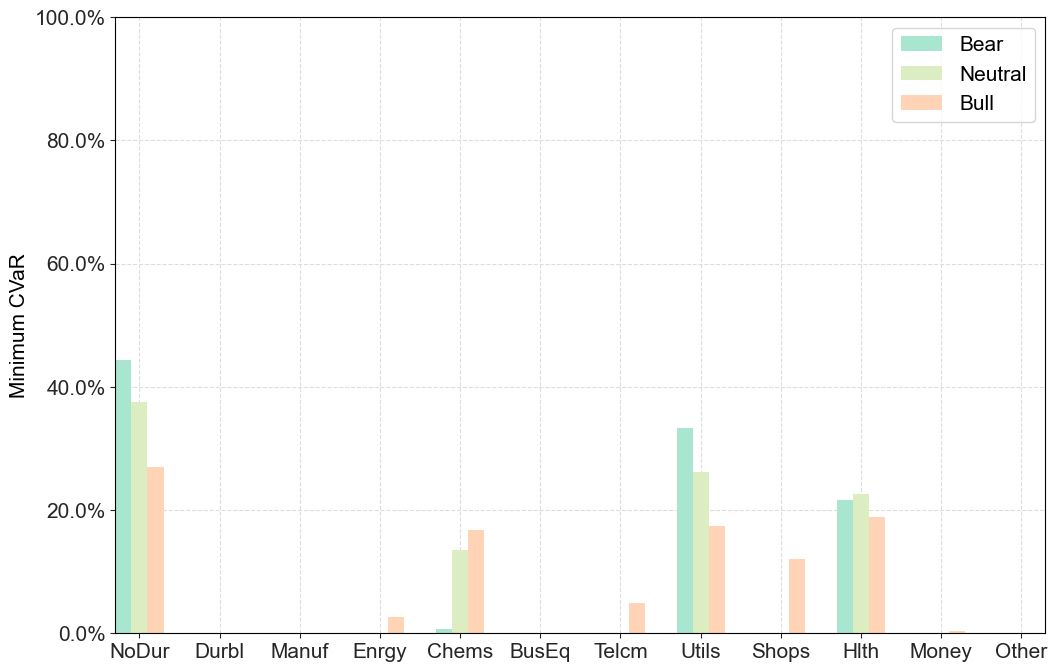

In [131]:
"""
Plotting
"""

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(np.arange(12) - 0.2, res_bear.x[:-1], width=0.2, label="Bear")
ax.bar(np.arange(12), res_neutral.x[:-1], width=0.2, label="Neutral")
ax.bar(np.arange(12) + 0.2, res_bull.x[:-1], width=0.2, label="Bull")
ax.legend();
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1));
ax.set_ylabel("Allocation")
ax.set_ylabel("Minimum CVaR")
ax.set_ylim([0.0, 1.0])
plt.xticks(np.arange(12), asset_list);

In [132]:
pd.DataFrame(data=beta_est[1, :], index=asset_list)

,0
NoDur,0.577028
Durbl,1.497712
Manuf,1.179698
Enrgy,0.968145
Chems,0.743710
BusEq,1.340216
Telcm,0.943348
Utils,0.471051
Shops,0.870784
Hlth,0.627796


# References

## Articles

[Meucci (2008), "The Black-Litterman Approach: Original Model and Extensions"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1117574)

[Rockafeller and Uryasev (2000)](https://www.ise.ufl.edu/uryasev/files/2011/11/CVaR1_JOR.pdf)